# Computing the Model

### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor

/Users/leforestierlucas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Model

In [6]:
## Here we are just retrieving the right cleaned csv file with the new target

new_df = pd.read_csv("../clean_data/newtarget_df.csv", index_col= 0)
new_df.drop(["Company", "Region"], axis =1, inplace = True)
num_features_names = list(new_df.columns)[5:]
new_df 

,Device,Market,SubMarket,Year,Target,LogDiffSpendings,LogDiffMarketSpends,LogDiffSubMarketSpends,LogDiffDevSpends,LogDiffCogs,LogDiffRevenue,LogDiffEbitda,LogDiffCogs_1,LogDiffRevenue_1,LogDiffEbitda_1
0,Amplifier/Comparator,Industrial,Manufacturing Equipment,2019,0.071659,0.015973,-0.066253,-0.022983,-0.049027,-0.002153,0.011358,0.036500,0.098100,0.093371,0.096860
1,Amplifier/Comparator,Industrial,Manufacturing Equipment,2020,-0.005333,0.012252,0.019868,0.040494,-0.003689,-0.048201,-0.068179,-0.226659,-0.002153,0.011358,0.036500
2,Amplifier/Comparator,Industrial,Manufacturing Equipment,2021,0.333657,0.360138,0.215225,0.179305,0.234120,0.068448,0.102157,0.553441,-0.048201,-0.068179,-0.226659
3,Amplifier/Comparator,Industrial,Manufacturing Equipment,2022,0.108157,0.117925,0.114147,0.079144,0.133584,0.015593,0.017160,-0.035969,0.068448,0.102157,0.553441
4,Amplifier/Comparator,Industrial,Manufacturing Equipment,2023,0.146973,0.045711,0.068025,-0.009323,-0.063393,-0.690697,0.088614,0.260177,0.015593,0.017160,-0.035969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18671,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2020,0.058855,-0.004677,0.153879,0.049009,0.085060,0.024836,-0.008282,-0.078562,0.064036,0.061363,0.095532
18672,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2021,0.227076,0.251314,0.248554,0.193021,0.276539,0.204158,0.235075,0.365411,0.024836,-0.008282,-0.078562
18673,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2022,-0.018415,-0.050844,0.120092,-0.026877,0.093313,0.051327,0.026996,-0.049583,0.204158,0.235075,0.365411
18674,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,-0.021244,-0.155353,-0.254600,-0.197578,-0.052669,0.849697,-0.242316,1.168255,0.051327,0.026996,-0.049583


In [3]:
# Function to compute the out-of-sample r2

def osr2(x, y, train):
    return 1 - (sum([(list(x)[k] - list(y)[k])**2 for k in range(len(y))]))/(sum([(np.mean(train) - list(y)[k])**2 for k in range(len(y))]))

In [7]:
# Getting the dataset ready, splitting it in train/test datasets

first_df = new_df[(new_df.Year <= 2022)]
y_train = np.array(first_df.Target)
X_train = first_df.drop(["Target", "Year"], axis = 1)
second_df = new_df[(new_df.Year >= 2023)]
y_test = np.array(second_df.Target)
X_test = second_df.drop(["Target", "Year"], axis = 1)

In [8]:
# Encoding the catagorical features

cat = ["Device", "Market", "SubMarket"]
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat)], remainder='passthrough')
encoder = full_pipeline.fit(X_train)

In [17]:
feature_names = full_pipeline.named_transformers_['cat'].get_feature_names_out(
    input_features=cat, # Specify the input feature type as 'string'
)

### The best Model (after tuning)

Be careful, it is not the R2 (or MSE) on the final target

In [11]:
model = RandomForestRegressor(n_estimators = 30, min_samples_split = 5, min_samples_leaf = 5, max_features = 1)
model.fit(encoder.transform(X_train), y_train)# , callbacks=[callbacks])
print(f"R2 score of the train set : {r2_score(model.predict(encoder.transform(X_train)), y_train)}")
print(f"R2 score of the test set : {r2_score(model.predict(encoder.transform(X_test)), y_test)}")
print(f"OSR2 : {osr2(model.predict(encoder.transform(X_test)), y_test, y_train)}")

R2 score of the train set : -0.2583291475373548
R2 score of the test set : -1.3794417598152475
OSR2 : 0.3541112060631417


In [23]:
new_df = pd.read_csv("../clean_data/newtarget_df.csv", index_col= 0)
prediction_df = new_df[(new_df.Year >= 2023)]
pred_df = prediction_df.copy()
comp_df = pred_df[["Company", "Device", "Market", "SubMarket", "Year"]]
pred_df.drop(["Company", "Year"], axis = 1, inplace = True)
pred = model.predict(encoder.transform(X_test))
comp_df["Pred"] = pred
comp_df.to_csv("../clean_data/test_pred_rf_log.csv")
comp_df

<ipython-input-23-1c1c070f8ea2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df["Pred"] = pred


,Company,Device,Market,SubMarket,Year,Pred
4,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2023,0.038894
5,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2024,-0.006489
10,ABB,Amplifier/Comparator,Industrial,Power & Energy,2023,0.041130
11,ABB,Amplifier/Comparator,Industrial,Power & Energy,2024,-0.017871
16,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2023,0.033075
...,...,...,...,...,...,...
18663,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2024,0.047401
18668,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2023,0.002772
18669,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2024,-0.014078
18674,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,-0.018825


### The tuning (optional to run)

In [10]:
# Running the Grid Search with Time series split

tscv = TimeSeriesSplit(n_splits=5, test_size=1000, gap = 3) ## Splitting so that the validation set is always after the train set


## All the values used in the grid search, can me modified but might add computational time
num_estimators=[30, 50, 60, 70, 100, 120, 150]
min_samples_split = [2, 3, 5, 7]
min_samples_leaf = [1, 3, 5]
max_features = ["sqrt", "log2", 1]

### For loop on all the possible combinations of hyperparameters
score = []
for num_esti in num_estimators:
    for mss in min_samples_split:
        for msl in min_samples_leaf:
            for mf in max_features:
                res = [num_esti, mss, msl, mf]
                rmse = []
                for train_index, test_index in tscv.split(X_train):
                    cv_train, cv_val = encoder.transform(X_train.iloc[train_index]), encoder.transform(X_train.iloc[test_index])
                    cv_y_train, cv_y_val = y_train[train_index], y_train[test_index]
                    model = RandomForestRegressor(n_estimators = num_esti, min_samples_split = mss, min_samples_leaf = msl, max_features = mf)
                    model.fit(cv_train, cv_y_train) 
                    rmse.append(np.sqrt(mean_squared_error(model.predict(cv_val), cv_y_val)))
                res.append(np.mean(rmse))
                score.append(res)

KeyboardInterrupt: 

num_estimators    75.000000
max_depth          5.000000
alpha              0.500000
lambda             0.700000
rmse               0.150497
Name: 129, dtype: float64


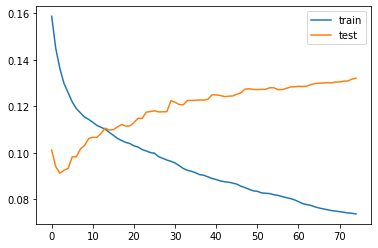

R2 score of the train set : 0.7576130198814338
R2 score of the train set : -0.037847710994001416
OSR2 : -0.21654478359557205


In [ ]:
# The score dataframe has all the MSE from all the combinations above
# We can know now what is the best one
score = pd.DataFrame(score, columns = ["num_estimators", "min_samples_split", "min_samples_leaf", "max_features","rmse"])
score.sort_values(by=['rmse'], ascending=False, inplace = True)
best_params = list(score.iloc[0, :])[:-1]
print(score.iloc[0, :])


## Running know the best model on the test set
model = RandomForestRegressor(n_estimators = int(best_params[0]), min_samples_split = int(best_params[1]), min_samples_leaf = int(best_params[2]), max_features = best_params[2])
model.fit(encoder.transform(X_train), y_train) 
print(f"R2 score of the train set : {r2_score(model.predict(encoder.transform(X_train)), y_train)}")
print(f"R2 score of the test set : {r2_score(model.predict(encoder.transform(X_test)), y_test)}")
print(f"OSR2 : {osr2(model.predict(encoder.transform(X_test)), y_test, y_train)}")
print(f"MAE Test : {mean_absolute_error(model.predict(encoder.transform(X_test)), y_test)}")

### Feature Importance

In [15]:
import time

## Looking at feature importance for the model chosen

start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.005 seconds


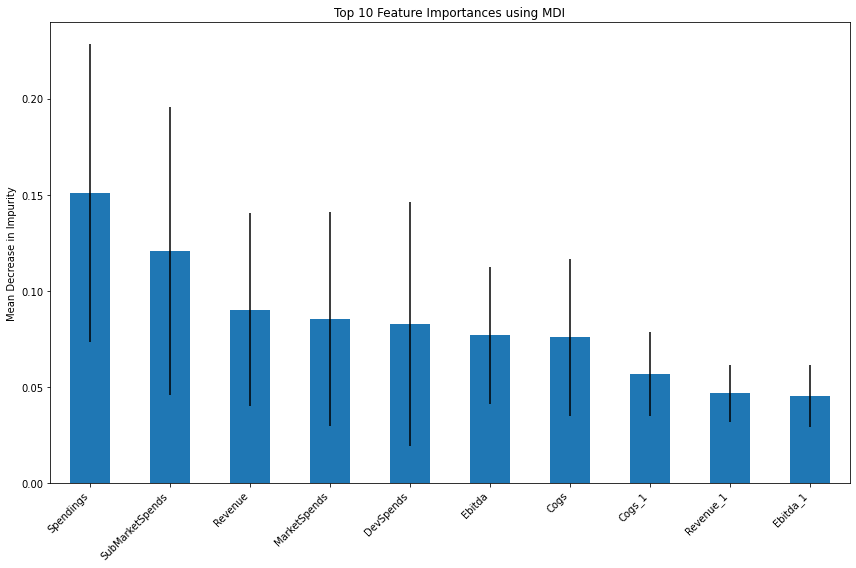

In [18]:
num_features_names = [x.replace('LogDiff', '') for x in num_features_names]
full_feature_names = list(feature_names) + list(num_features_names)
forest_importances = pd.Series(importances, index=full_feature_names)

# Select the top 10 features based on importances
top_features = forest_importances.nlargest(10)

# Make sure std is aligned with the index of top_features
std_series = pd.Series(std, index=full_feature_names)
std_for_top_features = std_series[top_features.index]

fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize as needed
top_features.plot.bar(yerr=std_for_top_features, ax=ax)

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title("Top 10 Feature Importances using MDI")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

plt.show()

In [19]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    model, encoder.transform(X_train).toarray(), y_train, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=full_feature_names)

Elapsed time to compute the importances: 9.050 seconds


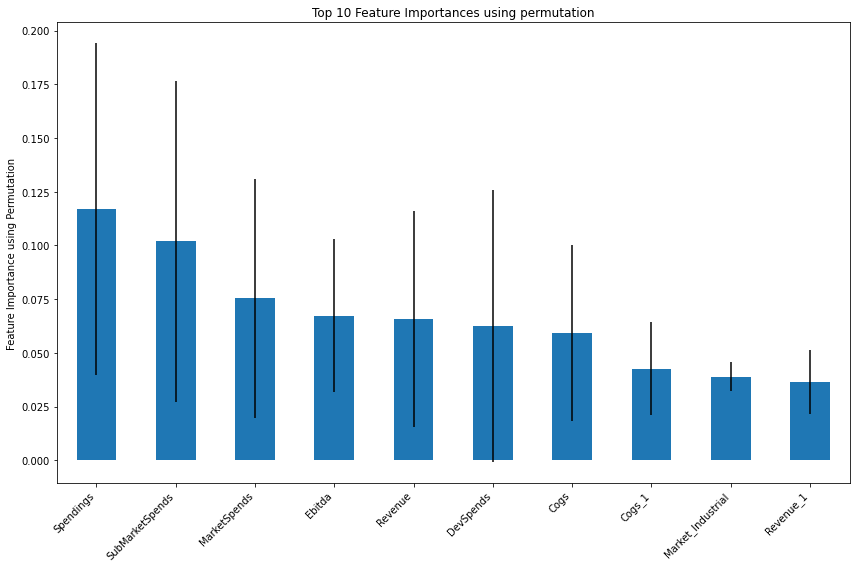

In [20]:
top_features = forest_importances.nlargest(10)

# Make sure std is aligned with the index of top_features
std_series = pd.Series(std, index=full_feature_names)
std_for_top_features = std_series[top_features.index]

fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize as needed
top_features.plot.bar(yerr=std_for_top_features, ax=ax)

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title("Top 10 Feature Importances using permutation")
ax.set_ylabel("Feature Importance using Permutation")
fig.tight_layout()

plt.show()

# Prediction (Test Set)

In [24]:
# Original Dataframe with the right target

df = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
df

,Company,Device,Market,SubMarket,Year,Value,Region,Spendings,MarketSpends,SubMarketSpends,DevSpends,Cogs,Cogs_1,Cogs_2,Revenue,Revenue_1,Revenue_2,Ebitda,Ebitda_1,Ebitda_2
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2018,7.951500,AmericasAsia & Oceania (exc. Japan)EMEAJapan,82.904,11486.855,926.369,3990.996,19059.000000,17278.000000,17270.0,27662.00,25196.00,24929.0,3227.000000,2929.000000,2987.0
1,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2019,8.616500,AmericasAsia & Oceania (exc. Japan)EMEAJapan,84.255,10750.418,905.298,3800.001,19018.000000,19059.000000,17278.0,27978.00,27662.00,25196.0,3347.000000,3227.000000,2929.0
2,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2020,8.565350,AmericasAsia & Oceania (exc. Japan)EMEAJapan,85.306,10966.167,942.751,3786.004,18123.000000,19018.000000,19059.0,26134.00,27978.00,27662.0,2668.000000,3347.000000,3227.0
3,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2021,12.353845,AmericasAsia & Oceania (exc. Japan)EMEAJapan,122.722,13599.835,1128.090,4785.001,19407.000000,18123.000000,19018.0,28945.00,26134.00,27978.0,4641.000000,2668.000000,3347.0
4,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2022,13.879158,AmericasAsia & Oceania (exc. Japan)EMEAJapan,138.207,15244.412,1221.082,5469.003,19712.000000,19407.000000,18123.0,29446.00,28945.00,26134.0,4477.000000,4641.000000,2668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27696,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2020,0.809700,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,454.000,25838.124,4852.175,11956.010,2445.000000,2385.000000,2237.0,4448.00,4485.00,4218.0,831.000000,899.000000,817.0
27697,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2021,1.271038,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,584.000,33129.151,5885.459,15765.008,2999.000000,2445.000000,2385.0,5627.00,4448.00,4485.0,1198.000000,831.000000,899.0
27698,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2022,1.229600,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,555.000,37356.594,5729.355,17307.004,3157.000000,2999.000000,2445.0,5781.00,5627.00,4448.0,1140.000000,1198.000000,831.0
27699,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,1.182734,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,474.999,28959.587,4701.997,16419.001,7385.362857,3157.000000,2999.0,4536.76,5781.00,5627.0,3668.885714,1140.000000,1198.0


In [25]:
## Retrieving the predictions above

pred_df_rf = pd.read_csv("../clean_data/test_pred_rf_log.csv", index_col = 0)
pred_df_rf

,Company,Device,Market,SubMarket,Year,Pred
4,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2023,0.038894
5,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2024,-0.006489
10,ABB,Amplifier/Comparator,Industrial,Power & Energy,2023,0.041130
11,ABB,Amplifier/Comparator,Industrial,Power & Energy,2024,-0.017871
16,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2023,0.033075
...,...,...,...,...,...,...
18663,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2024,0.047401
18668,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2023,0.002772
18669,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2024,-0.014078
18674,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,-0.018825


In [26]:
# Getting the Actual values of the target

test_values = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
test_values = df[(df.Year >= 2022)].iloc[:, :6]
test_values["Value"] = test_values.groupby(["Company", "Device", "Market", "SubMarket"])["Value"].shift(1)
test_values = test_values[~test_values['Value'].isnull()]
test_values

,Company,Device,Market,SubMarket,Year,Value
5,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2023,13.879158
6,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2024,16.234860
12,ABB,Amplifier/Comparator,Industrial,Power & Energy,2023,10.040442
13,ABB,Amplifier/Comparator,Industrial,Power & Energy,2024,10.927740
19,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2023,29.083150
...,...,...,...,...,...,...
27686,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2024,6.047200
27692,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2023,2.291600
27693,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2024,2.249966
27699,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,1.229600


In [27]:
## Function that reverse the new target into the old one

def inverselog(x, y):
    return ((y+1)*np.exp(x)) - 1

In [28]:
## Actually transforming the Pred into Spendings

pred_df_rf = pd.read_csv("../clean_data/test_pred_rf_log.csv", index_col = 0)
pred_df_rf = pred_df_rf.merge(test_values, how="left", on = ["Company", "Device", "Market", "SubMarket", "Year"])
pred_df_rf["Spendings"] = pred_df_rf.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
pred_df_rf["Value_2"] = pred_df_rf.groupby(["Company", "Device", "Market", "SubMarket"])["Spendings"].shift(1)
pred_df_rf["Value"] = np.where(pd.notna(pred_df_rf['Value_2']), pred_df_rf['Value_2'], pred_df_rf['Value'])
pred_df_rf.drop(["Spendings", "Value_2"], axis = 1, inplace = True)
pred_df_rf["Spendings"] = pred_df_rf.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
pred_df_rf

,Company,Device,Market,SubMarket,Year,Pred,Value,Spendings
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2023,0.038894,13.879158,14.469276
1,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2024,-0.006489,14.469276,14.369214
2,ABB,Amplifier/Comparator,Industrial,Power & Energy,2023,0.041130,10.040442,10.504007
3,ABB,Amplifier/Comparator,Industrial,Power & Energy,2024,-0.017871,10.504007,10.300247
4,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2023,0.033075,29.083150,30.094777
...,...,...,...,...,...,...,...,...
6210,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2024,0.047401,5.586878,5.906624
6211,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2023,0.002772,2.291600,2.300735
6212,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2024,-0.014078,2.300735,2.254593
6213,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,-0.018825,1.229600,1.188021


In [30]:
## Printing the final MSE

test_values = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
test_values_array = list(test_values[(test_values.Year >= 2023)].Value)
print(mean_absolute_error(list(pred_df_rf.Spendings), test_values_array))

1.9032660520037201


# Prediction 2025-2027

In [34]:
## Getting the prepared dataframe for the pred

prediction_df = pd.read_csv("../clean_data/new_pred.csv", index_col = 0)
prediction_df.reset_index(drop = True, inplace = True)

In [36]:
# Predicting with the actual model but on 2025 and later

pred_df = prediction_df.copy()
comp_df = pred_df[["Company", "Market", "SubMarket", "Device", "Year"]]
pred_df.drop(["Company", "Year"], axis = 1, inplace = True)
pred = model.predict(encoder.transform(pred_df))
comp_df["Pred"] = pred
comp_df

<ipython-input-36-c6282578f395>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df["Pred"] = pred


,Company,Market,SubMarket,Device,Year,Pred
0,ABB,Industrial,Manufacturing Equipment,Amplifier/Comparator,2025,0.021325
1,ABB,Industrial,Manufacturing Equipment,Amplifier/Comparator,2026,0.048814
2,ABB,Industrial,Manufacturing Equipment,Amplifier/Comparator,2027,0.045559
3,ABB,Industrial,Power & Energy,Amplifier/Comparator,2025,0.030419
4,ABB,Industrial,Power & Energy,Amplifier/Comparator,2026,0.040047
...,...,...,...,...,...,...
9267,Zebra Technologies,Wireless Communications,Infrastructure,Voltage Regulator/Reference,2026,-0.013325
9268,Zebra Technologies,Wireless Communications,Infrastructure,Voltage Regulator/Reference,2027,-0.016225
9269,Zebra Technologies,Wireless Communications,Other Wireless,Voltage Regulator/Reference,2025,0.061177
9270,Zebra Technologies,Wireless Communications,Other Wireless,Voltage Regulator/Reference,2026,0.015925


In [46]:
## Getting the values with the Spending target

test_values_pred = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
test_values_pred = test_values_pred[(test_values_pred.Year == 2024)].iloc[:, :6]
test_values_pred

,Company,Device,Market,SubMarket,Year,Value
6,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2024,15.408600
13,ABB,Amplifier/Comparator,Industrial,Power & Energy,2024,11.659800
20,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2024,31.593545
27,ABB,Analog Application Specific IC,Industrial,Power & Energy,2024,38.998155
34,ABB,Data Converters,Industrial,Manufacturing Equipment,2024,22.114800
...,...,...,...,...,...,...
27672,Zebra Technologies,Voltage Regulator/Reference,Computer Platforms,Tablet PCs,2024,7.356100
27679,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Carrier,2024,5.591700
27686,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2024,6.380500
27693,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2024,2.293834


In [47]:
## Getting the Value for the Year 2025 

test_values_pred_2025 = test_values_pred.copy()
test_values_pred_2025.Year = 2025
comp_df2025  = comp_df[comp_df.Year == 2025]
comp_df2025
test_values_pred_2025 = test_values_pred_2025.merge(comp_df2025, how = 'left', on = ["Company", "Device", "Market", "SubMarket", "Year"])
test_values_pred_2025.dropna(inplace = True)
test_values_pred_2025['Value'] = test_values_pred_2025.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
test_values_pred_2025.drop("Pred", axis = 1, inplace = True)
test_values_pred_2025

,Company,Device,Market,SubMarket,Year,Value
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2025,15.762266
1,ABB,Amplifier/Comparator,Industrial,Power & Energy,2025,12.050821
2,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2025,32.686941
3,ABB,Analog Application Specific IC,Industrial,Power & Energy,2025,41.559798
4,ABB,Data Converters,Industrial,Manufacturing Equipment,2025,22.625233
...,...,...,...,...,...,...
3102,Zebra Technologies,Voltage Regulator/Reference,Computer Platforms,Tablet PCs,2025,7.303412
3103,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Carrier,2025,6.654762
3104,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2025,7.353396
3105,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2025,2.279698


In [48]:
## Getting the Value for the Year 2026

test_values_pred_2026 = test_values_pred_2025.copy()
test_values_pred_2026.Year = 2026
comp_df2026  = comp_df[comp_df.Year == 2026]
comp_df2026
test_values_pred_2026 = test_values_pred_2026.merge(comp_df2026, how = 'left', on = ["Company", "Device", "Market", "SubMarket", "Year"])
test_values_pred_2026.dropna(inplace = True)
test_values_pred_2026['Value'] = test_values_pred_2026.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
test_values_pred_2026.drop("Pred", axis = 1, inplace = True)
test_values_pred_2026

,Company,Device,Market,SubMarket,Year,Value
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2026,16.600802
1,ABB,Amplifier/Comparator,Industrial,Power & Energy,2026,12.584074
2,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2026,35.039641
3,ABB,Analog Application Specific IC,Industrial,Power & Energy,2026,44.744681
4,ABB,Data Converters,Industrial,Manufacturing Equipment,2026,23.822387
...,...,...,...,...,...,...
3092,Zebra Technologies,Voltage Regulator/Reference,Computer Platforms,Tablet PCs,2026,7.110586
3093,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Carrier,2026,7.835942
3094,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2026,7.899770
3095,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2026,2.236285


In [49]:
## Getting the Value for the Year 2027

test_values_pred_2027 = test_values_pred_2026.copy()
test_values_pred_2027.Year = 2027
comp_df2027  = comp_df[comp_df.Year == 2027]
comp_df2027
test_values_pred_2027 = test_values_pred_2027.merge(comp_df2027, how = 'left', on = ["Company", "Device", "Market", "SubMarket", "Year"])
test_values_pred_2027.dropna(inplace = True)
test_values_pred_2027['Value'] = test_values_pred_2027.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
test_values_pred_2027.drop("Pred", axis = 1, inplace = True)
test_values_pred_2027

,Company,Device,Market,SubMarket,Year,Value
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2027,17.421222
1,ABB,Amplifier/Comparator,Industrial,Power & Energy,2027,13.188036
2,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2027,37.237926
3,ABB,Analog Application Specific IC,Industrial,Power & Energy,2027,47.710049
4,ABB,Data Converters,Industrial,Manufacturing Equipment,2027,24.998127
...,...,...,...,...,...,...
3077,Zebra Technologies,Voltage Regulator/Reference,Computer Platforms,Tablet PCs,2027,7.094128
3078,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Carrier,2027,9.079274
3079,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2027,8.311753
3080,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2027,2.184200


In [52]:
## Getting the final Dataframe with all the pred until 2027

final_pred = pd.concat([test_values_pred, test_values_pred_2025, test_values_pred_2026, test_values_pred_2027], axis = 0, ignore_index = True)
final_pred.sort_values(["Company", "Device", "Market", "SubMarket", "Year"], inplace = True)
final_pred.reset_index(drop = True, inplace = True)
final_pred.Value = final_pred.Value.apply(lambda x : max([x, 0]))
final_pred

,Company,Device,Market,SubMarket,Year,Value
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2024,15.408600
1,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2025,15.762266
2,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2026,16.600802
3,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2027,17.421222
4,ABB,Amplifier/Comparator,Industrial,Power & Energy,2024,11.659800
...,...,...,...,...,...,...
12363,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2027,2.184200
12364,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2024,1.173666
12365,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2025,1.310795
12366,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2026,1.347888


In [103]:
## Finally saving the final dataframe

final_pred.to_csv("../clean_data/all_companies_pred.csv")